In [1]:
# packages and plot parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
import numpy.ma as ma
import glob
import os
import re
from operator import mul
import sys
import time as time

plt.rcParams['figure.figsize'] = (10,4)

sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/jupyterfiles/") # go to parent dir
from read_binary import *

from aste_helper_funcs import *

### This script is based on the indices and code from below:
there is a function to define the basins generally which An has a function for
This is found at /home/atnguyen/matlab_mnt_nansen/HelenPillar_layers/lookat_layers_aste.m 
on line 147

### Some MATLAB to Python tips
read_float32(filename) = readbin
parsemeta(filename) = only read .meta with fields
rdmds(filename, time) = read .data file

#### Some tips on definitions
setTS_Ttend = definitions should be in data.diagnostics - check!

### Setting up files, bounds, faces

In [2]:
dirroot = "/scratch2/atnguyen/aste_90x150x60/"
dirrun = dirroot + "run_c67w_layers_03Jun2023_noOL_nlayers24nS24nT24_10d_newLayersDiags/"
dirgrid = dirroot + "GRID/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = dirrun + "diags/"

In [3]:
# reading in the TH and SLT bins
# read in the original array we fed
boundsT = rdmds(dirrun + "layers2TH", -1)
boundsT = boundsT[:,:,0].flatten()
nT = boundsT.shape[0]-1

boundsS = rdmds(dirrun + "layers1SLT", -1)
boundsS = boundsS[:,:,0].flatten()
nS = boundsS.shape[0]-1

binwidthT = boundsT[1:] - boundsT[:-1]   # this is real width delta
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = (boundsT[:-1] + boundsT[1:])/2
binmidS = (boundsS[:-1] + boundsS[1:])/2

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

print(binmidT.shape,binmidTp.shape)

(24,) (23,)


In [4]:
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    print(temp.shape)
    mygrid[fld] = temp.reshape(nz, ny, nx)
    print(temp.reshape(nz, ny, nx).shape)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)
    
# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

(50, 1350, 30)
(50, 450, 90)


In [5]:
# 126-130
xc = mygrid['XC']
yc = mygrid['YC']
rac = mygrid['RAC']
drf = mygrid['DRF']

In [6]:
d = rdmds(dirgrid + "Depth",-1)
d = np.reshape(d,(ny,nx))
class structtype():
    pass
fld = d
print(fld.shape)

dep =  get_aste_faces (d,nfx,nfy)

(450, 90)
nx 90
sz [450  90]
(1, 450, 90)
tmp (1, 150, 90)


In [7]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z
# hf1 = hf1[np.newaxis,:, :]
hf1.shape

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

SZ! (1, 300, 180)
shape of fld: (1, 300, 180)
(1, 90, 90)
(1, 90, 60)
(1, 90, 150)
(1, 450, 90)
compact shape (1, 450, 90)
(50, 450, 90) (1, 450, 90)


In [8]:
# 2d
iwetC2d = read_float32(dirgridw + "Index_wet_hFacC_2D_col6.bin")
iwetC2d = iwetC2d.astype("int32")
LwetC2d = iwetC2d.shape[0]
# 3d
iwetC = read_float32(dirgridw + "Index_wet_hFacC_col6.bin")
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]

# 2d
rac2d = read_float32(dirgridw + "RAC_" + str(LwetC2d) + ".data")
print(rac2d.shape)
# 3d
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

(16200,)


In [9]:
filename = dirmask + 'GATE_transports_v2_mskBasin_1to14.bin'
ind2d = read_float32(filename)
ind2d = ind2d.reshape(450,90)
# plt.pcolormesh(ind2d)
# plt.colorbar()

(40500,)
1152


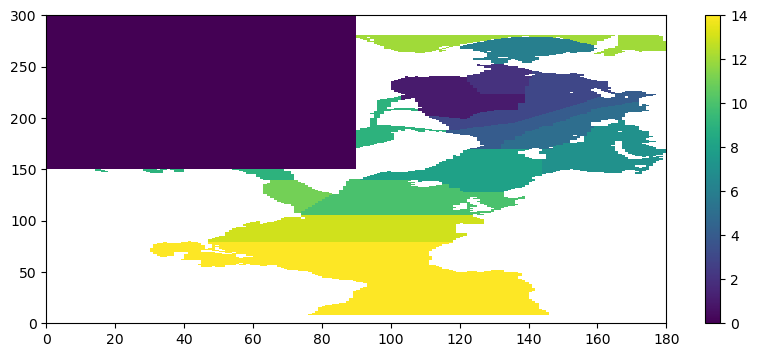

In [19]:
filename = dirmask + 'GATE_transports_v2_mskBasin_1to14.bin'
ind2d = read_float32(filename)

# SOMETHING IS CHANGING WHEN WE CHANGE THE TYPE, IN PCOLORMESH
ind2d_aste = get_aste_tracer(np.reshape(ind2d,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = ind2d.astype('int32')
print(ind2d.shape)

iBarents2D = np.where(ind2d == 7)  # see above
print(len(iBarents2D[0]))

In [20]:
# ind2d_aste = np.reshape(
ind2d_aste = get_aste_tracer(np.reshape(ind2d,(ny,nx)),nfx,nfy)
# plt.pcolormesh(ind2d_aste.astype("float64")[0,:,:])

### Define basins in all points, then wet points

In [21]:
# create the basins based on the values and make subplots
#        1           2          3           4         5         6        7         8      9     10    11       12      13         14
#strb={'CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA','SPG','LabSea','NPac','NAtlantic','AtlS30'};
idxs = np.arange(0,14,1)
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

# REDEFINE THESE AND REPLACE STRI with similar phrasing for wet indices
iCanada2D = np.where(ind2d == 1)[0]
iChukchiS2D = np.where(ind2d == 2)[0]
iMakarovB2D = np.where(ind2d == 3)[0]
iAmundsenB2D = np.where(ind2d == 4)[0]
iNansenB2D = np.where(ind2d == 5)[0]
iBeringS2D = np.where(ind2d == 6)[0]
iBarentsS2D = np.where(ind2d == 7)[0]
iGINs2D = np.where(ind2d == 8)[0]
iCAA2D = np.where(ind2d == 9)[0]
iSPG2D = np.where(ind2d == 10)[0]
iLabSea2D = np.where(ind2d == 11)[0]
iNPac2D = np.where(ind2d == 12)[0]
iNAtlantic2D = np.where(ind2d == 13)[0]
iAtlS302D = np.where(ind2d == 14)[0]


stri = np.array([iCanada2D,iChukchiS2D,iMakarovB2D,iAmundsenB2D,iNansenB2D,iBeringS2D,iBarentsS2D,iGINs2D,iCAA2D,
                iSPG2D,iLabSea2D,iNPac2D,iNAtlantic2D,iAtlS302D],dtype = "object")

# make subplots based on these - hope we did this right
# myzero = np.zeros((ny*nx))
# fig,axs = plt.subplots(len(stri),figsize = (2,12))
# for i in idxs:
#     myzerotmp = myzero.copy() # copy for reference in loop
#     myzerotmp[stri[i]] = 1
#     myzerotmp =  np.reshape(myzerotmp,(ny,nx))
#     myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
#     axs[i].pcolormesh(myzerotmp[0,:,:])

In [22]:
# FIX THIS THING - SHOULD BE SAME NUM OF POINTS WET AND DRY
# debugging missing numbers

filename = dirmask + 'GATE_transports_v2_mskBasin_1to14.bin'
ind2d = read_float32(filename)

iwetC2d_o = read_float32(dirgridw + "Index_wet_hFacC_2D_col6.bin")
iwetC2d_o[np.isnan(iwetC2d_o)] = -10
iwetC2d = iwetC2d_o.astype("int32")
iwetC2d -= 1

print(ind2d.shape)

(40500,)


In [23]:

# create the basins based on the values and make subplots
#        1           2          3           4         5         6        7         8      9     10    11       12      13         14
#strb={'CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA','SPG','LabSea','NPac','NAtlantic','AtlS30'};
ind2d_wet = ind2d[iwetC2d]

# for using wet indices, try to see where ind2d_wet
iwet_Canada2D = np.where(ind2d_wet == 1)[0]
iwet_ChukchiS2D = np.where(ind2d_wet == 2)[0]
iwet_MakarovB2D = np.where(ind2d_wet == 3)[0]
iwet_AmundsenB2D = np.where(ind2d_wet == 4)[0]
iwet_NansenB2D = np.where(ind2d_wet == 5)[0]
iwet_BeringS2D = np.where(ind2d_wet == 6)[0]
iwet_BarentsS2D = np.where(ind2d_wet == 7)[0]
iwet_GINs2D = np.where(ind2d_wet == 8)[0]
iwet_CAA2D = np.where(ind2d_wet == 9)[0]
iwet_SPG2D = np.where(ind2d_wet == 10)[0]
iwet_LabSea2D = np.where(ind2d_wet == 11)[0]
iwet_NPac2D = np.where(ind2d_wet == 12)[0]
iwet_NAtlantic2D = np.where(ind2d_wet == 13)[0]
iwet_AtlS302D = np.where(ind2d_wet == 14)[0]

stri_wet = np.array([iwet_Canada2D,iwet_ChukchiS2D,iwet_MakarovB2D,iwet_AmundsenB2D,iwet_NansenB2D,iwet_BeringS2D,iwet_BarentsS2D,iwet_GINs2D,iwet_CAA2D,
                 iwet_SPG2D,iwet_LabSea2D,iwet_NPac2D,iwet_NAtlantic2D,iwet_AtlS302D],dtype = "object")

# compare to try and make sure we did this right
for x,y in zip(stri,stri_wet):
    print(x.shape,y.shape)

(991,) (991,)
(435,) (435,)
(1043,) (1043,)
(693,) (693,)
(658,) (658,)
(630,) (630,)
(1152,) (1152,)
(1207,) (1207,)
(485,) (485,)
(1508,) (1508,)
(369,) (369,)
(849,) (849,)
(1691,) (1691,)
(4330,) (4330,)


## 2D field of Basins now we have defined indices

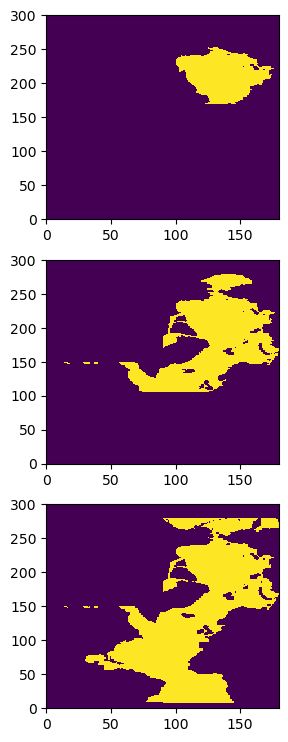

In [24]:
# now we should be around line 179
iBasinArctic = np.concatenate((iCanada2D,iChukchiS2D,iMakarovB2D,iAmundsenB2D,iNansenB2D))
iBasinMedSPG = np.concatenate ((iBasinArctic, iBeringS2D, iBarentsS2D,iGINs2D,iCAA2D,iSPG2D,iLabSea2D))
# iBasinGlobal = np.concatenate((iBasinMedSPG, iNPac2D,iNAtlantic2D,iAtlS302D))
iBasinGlobal = iwetC2d[np.where(hf2d>0)[0]] ## QUESTION FOR AN - WHAT IS THE CORRECT WAY TO REFERENCE THIS

# make subplots based on these - hope we did this right
myzero = np.zeros((ny*nx))
fig,axs = plt.subplots(3,figsize = (3,9))

myzerotmp = myzero.copy() # copy for reference in loop
myzerotmp[iBasinArctic] = 1
myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
axs[0].pcolormesh(myzerotmp[0,:,:])

myzerotmp = myzero.copy() # copy for reference in loop
myzerotmp[iBasinMedSPG] = 1
myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
axs[1].pcolormesh(myzerotmp[0,:,:])

myzerotmp = myzero.copy() # copy for reference in loop
myzerotmp[iwetC2d[np.where(hf2d>0)[0]]] = 1
myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
axs[2].pcolormesh(myzerotmp[0,:,:])

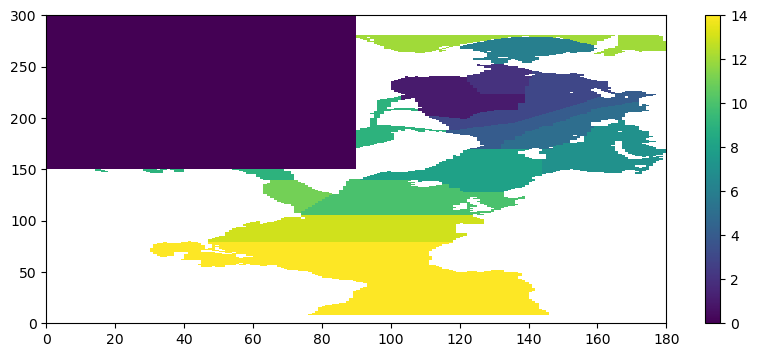

In [25]:
# make mskBasin
filename = dirmask + 'GATE_transports_v2_mskBasin_1to14.bin'
ind2d = read_float32(filename)

# SOMETHING IS CHANGING WHEN WE CHANGE THE TYPE, IN PCOLORMESH
ind2d_aste = get_aste_tracer(np.reshape(ind2d,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

In [26]:
# myzerotmp

### try read meta with the variable values?

In [27]:
if nx == 90:
    tsstr = np.arange(48,490,24).astype(str)
    for i in range(len(tsstr)):
        myt = tsstr[i].zfill(10)
        tsstr[i] = myt
elif nx == 270:
    print("not sure indexing")
# tsstr

t2 = tsstr[0]
t2

'0000000048'

In [29]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend." + t2 + ".meta")
nFldsT = metaT["fldList"]
metaS=parsemeta(dirdiags + "LAYERS/layers_3d_Stend." + t2 + ".meta")
nFldsS = metaS["fldList"]

if len(nFldsT) == 12: 
    ifldT = np.array([0, 1,2,3,4,5])    # not sure if this should be -1 since we're in python
    setTtend=nFldsT.copy()
    ifldS=np.array([6, 7,8, 9 ,10 ,11])
    setStend=nFldsS.copy()

elif len(nFldsT) == 18:
    ifldT = np.array([1,2,3,4,5,6])
    setTtend=nFldsT.copy()
    ifldS=np.array([7,8, 9 ,10 ,11 ,12])
    setStend=nFldsS.copy()
    # ifldT=[1 2 3 4 5 8];
# 219     setTtend={'LaTs2TH','LaTh2TH','LaTz2TH','LTha2TH','LTza2TH','LTBh2TH','LTBz2TH','LTto2TH',... %G_T, m/s
# 220               'LaTs1SLT','LaTh1SLT','LaTz1SLT','TzKp1SLT','TzRe1SLT','LTha1SLT','LTza1SLT','LTBh1SLT','LTBz1SLT','LTto1SLT'};
# 221   %layers_3d_Ttend (18 flds), G_S
# 222     ifldS=[9 10 11 14 15 18];
# 223     setStend={'LaSs2TH','LaSh2TH','LaSz2TH','LSha2TH','LSza2TH','LSBh2TH','LSBz2TH','LSto2TH',... %G_S, m/s
# 224               'LaSs1SLT','LaSh1SLT','LaSz1SLT','SzKp1SLT','SzRe1SLT','LSha1SLT','LSza1SLT','LSBh1SLT','LSBz1SLT','LSto1SLT'};

In [15]:
print(rac2d.shape)
print(hf2d.shape)

(16200,)
(16200,)


In [31]:
rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))
# junk = rac2dtile[-1,:] - rac2dtile[0,:]
# np.sum(junk)

In [32]:
# assuming the same order we can create a dtype object for all basins
indBasin = np.array([],dtype="object")
for ib in range(len(strb)):
    filename = dirmask + "ind2d_" + strb[ib] + ".bin"
    this_2d = read_float32(filename)
    this_2d = this_2d.astype("int32")
    indBasin = np.append(indBasin,this_2d)  # now we append the basin indices in order

In [33]:
# try to remake the label array in wet points only
# make an array of wet points that are all labeled
wet_labels = np.zeros((iwetC2d.shape))


wet_basinpts = np.concatenate(stri_wet)
np.sort(wet_basinpts)

np.intersect1d(stri_wet[0],iwetC2d,return_indices=True)
# stri_wet[0]
# iwetC2d
wet_basinpts.shape

# iCanada2D[~np.isin(iCanada2D, np.intersect1d(iCanada2D, iwetC2d))

for ib in range(len(stri)):
    iBas = stri[ib]
    notinc = iBas[~np.isin(iBas, np.intersect1d(iBas, iwetC2d))]

In [34]:
G_T = {}
# set dictionaries for subbasins
for ib in range(len(strb)):
    G_T[strb[ib]] = {}
    
# now loop through
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float32_skip(dirdiags + "LAYERS/" + "layers_3d_Ttend." + tsstr[0] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldT.shape[0]-1:
        residT = tmp
    else:
        residT = residT-tmp

    # loop through ib each basin for the chosen ifldT
    # REPLACE INDBASINIB, THIS SHOULD BE WET POINTS OF BASINS
    for ib in range(len(strb)):
        a = np.nansum(tmp[:,stri_wet[ib]],axis=1)
        G_T[strb[ib]][setTtend[ifldT[i]]] = a

# loop through again to calculate resid
for ib in range(len(strb)):
    G_T[strb[ib]]["residT"] = np.nansum(residT[:,stri_wet[ib]],axis=1)

In [35]:
G_T = {}
# set dictionaries for subbasins
for ib in range(len(strb)):
    G_T[strb[ib]] = {}
    
# now loop through
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float32_skip(dirdiags + "LAYERS/" + "layers_3d_Ttend." + tsstr[0] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldT.shape[0]-1:
        residT = tmp
    else:
        residT = residT-tmp

    # loop through ib each basin for the chosen ifldT
    # REPLACE INDBASINIB, THIS SHOULD BE WET POINTS OF BASINS
    for ib in range(len(strb)):
        a = np.nansum(tmp[:,stri_wet[ib]],axis=1)
        G_T[strb[ib]][setTtend[ifldT[i]]] = a

# loop through again to calculate resid
for ib in range(len(strb)):
    G_T[strb[ib]]["residT"] = np.nansum(residT[:,stri_wet[ib]],axis=1)

In [36]:
G_T['CanadaB'].keys()

dict_keys(['LTto2TH', 'LTza2TH', 'LTha2TH', 'LaTz2TH', 'LaTh2TH', 'LaTs2TH', 'residT'])

In [43]:
# create G_S for all basins (line 258)
G_S = {}
for ib in range(len(strb)):
    G_S[strb[ib]] = {}

# now loop through similar to ifldS
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float32_skip(dirdiags + "LAYERS/" + "layers_3d_Stend." + tsstr[0] + ".data", nx*ny*(nT-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldS.shape[0]-1:
        residS = tmp
    else:
        residS = residS-tmp

    # loop through ib each basin for the chosen ifldT
    for ib in range(len(strb)):
        G_S[strb[ib]][setStend[ifldS[i]]] = np.nansum(tmp[:,stri_wet[ib]],axis=1)

# loop through again to calculate resid
for ib in range(len(strb)):
    G_S[strb[ib]]["residS"] = np.nansum(residS[:,stri_wet[ib]],axis=1)

#### We now have set G_S and G_T. Now can do TS space

In [44]:
# now do TS space and squeeze
setTSp = ['LaHc_TS']

if len(nFldsT) == 18:
    setTS_Stend = ['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'SzKp_TS', 'SzRe_TS', 'LSha_TS', 'LSza_TS', 'LSBh_TS', 'LSBz_TS', 'LSto_TS']
    setTS_Ttend = ['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'TzKp_TS', 'TzRe_TS', 'LTha_TS', 'LTza_TS', 'LTBh_TS', 'LTBz_TS', 'LTto_TS']
elif len(nFldsT) == 12:
    setTS_Stend = ['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']
    setTS_Ttend = ['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'LTha_TS', 'LTza_TS', 'LTto_TS']

## Read in Jy, Jx  -- double check shapes!!
should be integrated over dS to get G_T (m/s)
transformation of water towards higher salinities

In [45]:
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
for ib in range(len(strb)):
    Jy[strb[ib]] = {}
    Jy[strb[ib]]['G_T'] = {}
    Jy[strb[ib]]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(450,90)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = dirdiags + "LAYERS_Cwet/layers_3d_TSjoint_Ttend_" + str(LwetC2d) + "." + tsstr[0] + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        c = np.full((nS - 1, nT - 1,nx * ny), np.nan)
        c[:, :,iwetC2d] = tmp
        c = np.reshape(c, (nT - 1, nS - 1,ny, nx))
        small = rac*hf1
        
        c = np.nansum(np.nansum(c * np.tile(small[np.newaxis,np.newaxis,:,:], (nT-1, nS-1,1,1)), axis=(2, 3))) * ffac
        d = np.nansum(c * binwidthS1)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    if len(nFldsT) == 18:
        if i == len(setTS_Ttend)-1:
            residT = tmp
        elif i!=3 and i != 4 and i != 8 and i != 9:
            residT = residT - tmp
    elif len(nFldsT) == 12:
        if i == len(setTS_Ttend)-1:
            residT = tmp
        else:
            residT = residT - tmp

    for ib in range(len(strb)):
        # use stri_wet, strb is names of basins
        #print(tmp.shape)
        tmp1 = np.nansum(tmp[:,:,stri_wet[ib]],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
        # TEST:
        tmp1 = tmp1.T
        #print(tmp1.shape)
        tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
        #print(tmp2.shape)
        Jy[strb[ib]][setTS_Ttend[i]] = tmp1
        Jy[strb[ib]]['G_T'][setTS_Ttend[i]] = tmp2

for ib in range(len(strb)):
    myresid = np.nansum(residT[:,:,stri_wet[ib]],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    myresid = myresid.T
    Jy[strb[ib]]["residT"] = myresid
    Jy[strb[ib]]["G_T"]["residT"] = np.nansum(Jy[strb[ib]]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

# set units and labels
Jy["unit"] = "m/s/psu"
Jy["G_T"] = {}
Jy["G_T"]["unit"] = "m/s"
Jy["G_T"]["descr"] = "G_T=integral(Jy,dS)"

(23, 23, 16200)
(23, 23, 16200)
(23, 23, 16200)
(23, 23, 16200)
(23, 23, 16200)
(23, 23, 16200)


In [46]:
# 327
Jx = {}
# set each basin to its own dictionary
for ib in range(len(strb)):
    Jx[strb[ib]] = {}
    Jx[strb[ib]]['G_S'] = {}
    Jx[strb[ib]]['G_S']['residS'] = {}

# rac = mygrid['RAC']
# hf1 = hf1.reshape(450,90)

for i in range(len(setTS_Stend)-1, -1, -1):
    filename = dirdiags + "LAYERS_Cwet/layers_3d_TSjoint_Stend_" + str(LwetC2d) + "." + tsstr[0] + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    if len(nFldsS) == 18:
        if i == len(setTS_Stend)-1:
            residS = tmp
        elif i!=3 and i != 4 and i != 8 and i != 9:
            residS = residS - tmp
    elif len(nFldsS) == 12:
        if i == len(setTS_Stend)-1:
            residS = tmp
        else:
            residS = residS - tmp

    for ib in range(len(strb)):
        # use stri_wet, strb is names of basins
        tmp1 = np.nansum(tmp[:,:,stri_wet[ib]],axis=2)   # should be of shape nS-1, nT-1
        # TEST
        tmp1 = tmp1.T
        thisbinwidthT1 = np.tile(binwidthT1[:,np.newaxis],(1, nS - 1))
        tmp2 = np.nansum(tmp1 * thisbinwidthT1, axis=1)                 # second dim is T because this is S tend
        Jx[strb[ib]][setTS_Stend[i]] = tmp1
        Jx[strb[ib]]['G_S'][setTS_Stend[i]] = tmp2

for ib in range(len(strb)):
    tmp1 = np.nansum(residS[:,:,stri_wet[ib]],axis=2)    # sum over geo space
    mytileT1 = np.tile(binwidthT1[np.newaxis,:],(nS-1,1))  # nS-1 x nT-1
    # TEST
    mytileT1 = mytileT1.T
    tmp2 = np.nansum(tmp1 * mytileT1, axis=0)     # sum over T ( dimension 0)
    Jx[strb[ib]]["residS"] = tmp1    # should be of shape nS-1, nT-1
    Jx[strb[ib]]["G_S"]["residS"] = tmp2 #should be of shape nT-1

# set units and labels
Jx["descr"] = "m/s/degC"
Jx["G_S"] = {}
Jx["G_S"]["descr"] = "[m/s], e.g., integral(LSto_TS,dT) = LSto1SLT"

In [47]:
# not sure how to save file here (line 379)

In [48]:
# first need to create mskBasin, mskBasin3d, indBasin2d, indBasin3d
mskBasin = ind2d_aste[0,:,:]
mskBasin3d = np.tile(mskBasin[:,:,np.newaxis],nz)

ind2d_aste.shape

(1, 300, 180)

In [60]:
t2
int_t2 = int(t2)

In [61]:
# get volumes from geographic grids (384)
filename = dirrun + "diags/STATE/state_3d_set1" + "." + t2 + ".meta"       # just choosing a file
meta_state_3d_set1 = parsemeta(filename)
fldlist = np.array(meta_state_3d_set1['fldList'])
varnames = np.array(['THETA','SALT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
T,its,meta = rdmds(dirrun + "diags/STATE/state_3d_set1",int_t2,returnmeta=True,rec=recs[0])
S,its,meta = rdmds(dirrun + "diags/STATE/state_3d_set1",int_t2,returnmeta=True,rec=recs[1])

In [62]:
Tflat = np.reshape(T,T.flatten().shape[0])
T = Tflat[iwetC]
Sflat = np.reshape(S,S.flatten().shape[0])
S = Sflat[iwetC]

In [63]:
vv = np.zeros((nz,ny,nx))
for k in range(len(drf)):
    vv[k,:,:] = rac * drf[k] * hf1

In [64]:
vv.shape

(50, 450, 90)

## Try plotting G_S, G_T from standard layer outputs

In [65]:
jb = 0
iendT = np.where(G_T[strb[jb]]['LTto2TH'] > 0)[0]
iendT = min(nT - 1, max(iendT) + 10)
iendT

# np.arange(iendT[0]-1,iendT[-1]+12)

12

In [66]:
ibegT = np.where(G_T[strb[jb]]['LTto2TH']>0)[0]
ibegT = max(0, min(ibegT) - 11)
# iiT = np.

0
(19,) (12,)


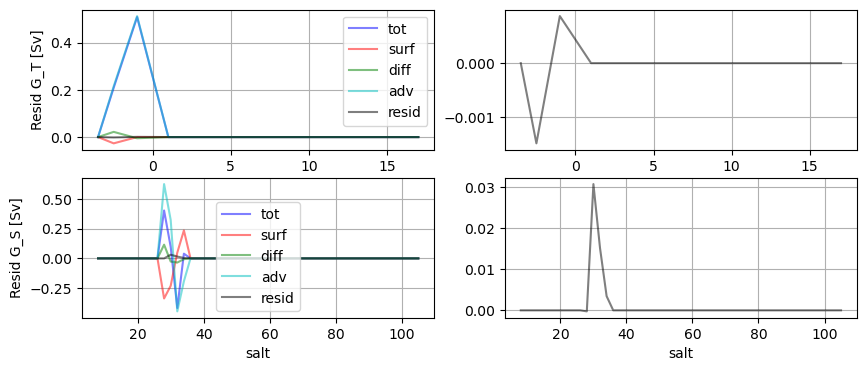

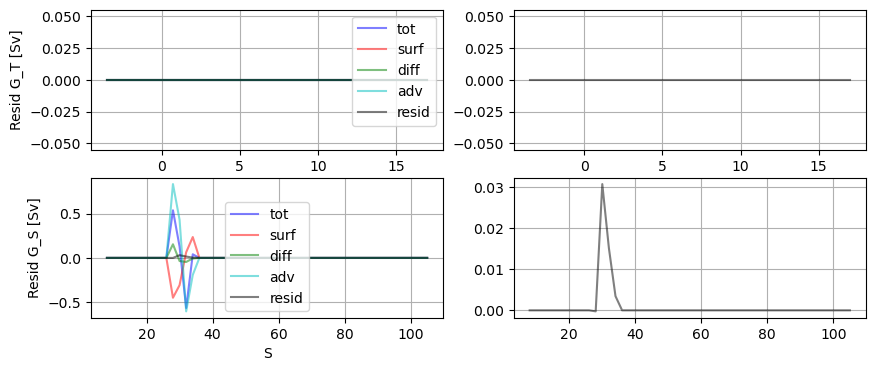

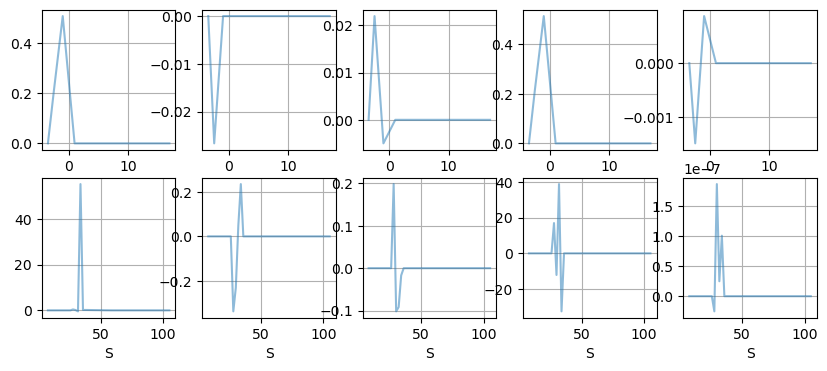

In [67]:
for i in range(len(strb[:1])):
    jb = i
    print(jb)
    # create iendT and ibegT
    iendT = np.where(G_T[strb[jb]]['LTto2TH'] > 0)[0]
    iendT = min(nT - 1, max(iendT) + 10)
    ibegT = np.where(G_T[strb[jb]]['LTto2TH']>0)[0]
    ibegT = max(0, min(ibegT) - 11)
    iiT = np.arange(ibegT, iendT)
    
    # create iendS and ibegS
    iendS = np.where(G_S[strb[jb]]['LSto1SLT']>0)[0]
    if len(iendS) == 0:
        iendS = np.array([500])
    iendS = min(nS-1, max(iendS) + 10)
    ibegS = np.where(G_S[strb[jb]]['LSto1SLT']>0)[0]
    if len(ibegS) == 0:
        ibegS = np.array([-500])
    ibegS = max(1, min(ibegS) - 10)
    iiS = np.arange(ibegS, iendS)

    print(iiS.shape,iiT.shape)

    plt.figure(1)
    plt.clf()
    # Create a subplot with 2 rows, 2 columns, and select the first subplot
    plt.subplot(221)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LTto2TH'][iiT], 'b-',alpha=0.5,label="tot")
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LaTs2TH'][iiT], 'r-',alpha=0.5,label="surf")
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LaTh2TH'][iiT] + G_T[strb[jb]]['LaTz2TH'][iiT], 'g-',alpha=0.5,label="diff")
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LTha2TH'][iiT] + G_T[strb[jb]]['LTza2TH'][iiT], 'c-',alpha=0.5,label="adv")
    plt.plot(binmidT[iiT], G_T[strb[jb]]['residT'][iiT], 'k-',alpha=0.5,label="resid")
    plt.legend(loc="best")
    plt.xlabel("pot T")
    plt.ylabel('Resid G_T [Sv]')
    plt.grid()
    plt.subplot(222)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['residT'][iiT], 'k-', alpha=0.5,label="resid")
    plt.xlabel("pot T")
    #plt.ylabel("resid G_T")
    plt.grid()
    plt.subplot(223)
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LSto1SLT'][iiS], 'b-',alpha=0.5,label="tot")
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LaSs1SLT'][iiS], 'r-',alpha=0.5,label="surf")
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LaSh1SLT'][iiS] + G_S[strb[jb]]['LaSz1SLT'][iiS], 'g-',alpha=0.5,label="diff")
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LSha1SLT'][iiS] + G_S[strb[jb]]['LSza1SLT'][iiS], 'c-',alpha=0.5,label="adv")
    plt.plot(binmidS[iiS], G_S[strb[jb]]['residS'][iiS], 'k-',alpha=0.5,label="resid")
    plt.legend(loc="best")
    plt.xlabel("salt")
    plt.ylabel('Resid G_S [Sv]')
    plt.grid()
    plt.subplot(224)
    plt.plot(binmidS[iiS], G_S[strb[jb]]['residS'][iiS], 'k-', alpha=0.5,label="resid")
    plt.xlabel("salt")
    plt.grid()

    plt.figure(2)
    plt.subplot(221)
    plt.plot(binmidT[iiT], Jy[strb[jb]]['G_T']['LTto_TS'][iiT], 'b-',alpha=0.5,label="tot")
    plt.plot(binmidT[iiT], Jy[strb[jb]]['G_T']['LaTs_TS'][iiT], 'r-',alpha=0.5,label="surf")
    plt.plot(binmidT[iiT], Jy[strb[jb]]['G_T']['LaTh_TS'][iiT] + Jy[strb[jb]]['G_T']['LaTz_TS'][iiT], 'g-',alpha=0.5,label="diff")
    plt.plot(binmidT[iiT], Jy[strb[jb]]['G_T']['LTha_TS'][iiT] + Jy[strb[jb]]['G_T']['LTza_TS'][iiT], 'c-',alpha=0.5,label="adv")
    plt.plot(binmidT[iiT], Jy[strb[jb]]['G_T']['residT'][iiT], 'k-',alpha=0.5,label="resid")
    plt.legend(loc="best")
    plt.xlabel("pot T")
    plt.ylabel('Resid G_T [Sv]')
    plt.grid()
    plt.subplot(222)
    plt.plot(binmidT[iiT],Jy[strb[jb]]['G_T']['residT'][iiT], 'k-',alpha=0.5,label="resid")
    plt.grid()
    plt.subplot(223)
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['LSto_TS'][iiS], 'b-',alpha=0.5,label="tot")
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['LaSs_TS'][iiS], 'r-',alpha=0.5,label="surf")
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['LaSh_TS'][iiS] + Jx[strb[jb]]['G_S']['LaSz_TS'][iiS], 'g-',alpha=0.5,label="diff")
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['LSha_TS'][iiS] + Jx[strb[jb]]['G_S']['LSza_TS'][iiS], 'c-',alpha=0.5,label="adv")
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['residS'][iiS], 'k-',alpha=0.5,label="resid")
    plt.legend(loc="best")
    plt.xlabel("S")
    plt.ylabel('Resid G_S [Sv]')
    plt.grid()
    plt.subplot(224)
    plt.plot(binmidS[iiS], Jx[strb[jb]]['G_S']['residS'][iiS], 'k-',alpha=0.5)
    plt.grid()

    plt.figure(3)
    plt.subplot(2,5,1)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LTto2TH'][iiT] - Jy[strb[ib]]['G_T']['LTto_TS'][iiT], '-',alpha=0.5)
    plt.xlabel("T")
    plt.grid()
    plt.subplot(2,5,6)
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LSto1SLT'][iiS] - Jx[strb[ib]]['G_S']['LSto_TS'][iiS], '-',alpha=0.5)
    plt.xlabel("S")
    plt.grid()
    plt.subplot(2,5,2)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LaTs2TH'][iiT] - Jy[strb[ib]]['G_T']['LaTs_TS'][iiT], '-',alpha=0.5)
    plt.xlabel("T")
    plt.grid()
    plt.subplot(2,5,7)
    plt.plot(binmidS[iiS], G_S[strb[jb]]['LaSs1SLT'][iiS] - Jx[strb[ib]]['G_S']['LaSs_TS'][iiS], '-',alpha=0.5)
    plt.xlabel("S")
    plt.grid()
    plt.subplot(2,5,3)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LaTh2TH'][iiT] + G_T[strb[jb]]['LaTz2TH'][iiT] - \
             Jy[strb[ib]]['G_T']['LaTh_TS'][iiT] + Jy[strb[jb]]['G_T']['LaTz_TS'][iiT], '-',alpha=0.5)
    plt.xlabel("T")
    plt.grid()
    plt.subplot(2,5,8)
    plt.plot(binmidS[iiS],G_S[strb[jb]]['LaSh1SLT'][iiS] + G_S[strb[jb]]["LaSz1SLT"][iiS] - \
             Jx[strb[jb]]['G_S']["LaSh_TS"][iiS] + Jx[strb[jb]]["G_S"]["LaSz_TS"][iiS],'-',alpha=0.5)
    plt.xlabel("S")
    plt.grid()
    plt.subplot(2,5,4)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['LTha2TH'][iiT] + G_T[strb[jb]]['LTza2TH'][iiT] - \
             Jy[strb[ib]]['G_T']['LTha_TS'][iiT] + Jy[strb[jb]]['G_T']['LTza_TS'][iiT], '-',alpha=0.5)
    plt.xlabel("T")
    plt.grid()
    plt.subplot(2,5,9)
    plt.plot(binmidS[iiS],G_S[strb[jb]]['LSha1SLT'][iiS] + G_S[strb[jb]]["LSza1SLT"][iiS] - \
             Jx[strb[jb]]['G_S']["LSha_TS"][iiS] + Jx[strb[jb]]["G_S"]["LSza_TS"][iiS],'-',alpha=0.5)
    plt.xlabel("S")
    plt.grid()
    plt.subplot(2,5,5)
    plt.plot(binmidT[iiT], G_T[strb[jb]]['residT'][iiT] - Jy[strb[ib]]['G_T']['residT'][iiT],'-',alpha=0.5)
    plt.xlabel("T")
    plt.grid()
    plt.subplot(2,5,10)
    plt.plot(binmidS[iiS],G_S[strb[jb]]['residS'][iiS] - Jx[strb[jb]]['G_S']["residS"][iiS],'-',alpha=0.5)
    plt.xlabel("S")
    plt.grid()

In [71]:
# now create vectors (366) - this is not correct I think
vol_distrib = {}
dT,dS = np.meshgrid(binwidthT,binwidthS)
i = 1

filename = dirdiags + "LAYERS_Cwet/layers_3d_TSjoint_p_" + str(LwetC2d) + "." + tsstr[0] + ".data"
tmp = read_float32_skip(filename, LwetC2d*(nS)*(nT),i-1)

tmp = np.reshape(tmp,(nT,nS,LwetC2d))              # LwetC2d x nS x nT
small = rac2d * hf2d
small = np.tile(small[np.newaxis,np.newaxis,:],(nT,nS,1))

tmp = tmp * small * ffac

for ib in range(len(strb)):
    tmp1 = np.nansum(tmp[:,:,stri_wet[ib]],axis=2)
    tmp1 = tmp1.T                 # WHY???
    tmp1[tmp1 == 0] = np.nan
    vol_distrib[strb[ib]] = tmp1 / dT / dS  # [m^3 / (degC psu)]

In [72]:
# try plotting TS diagrams
Tbin,Sbin = np.meshgrid(boundsT,boundsS)
# vol_distrib["CanadaB"]
vol_distrib[strb[0]].shape
strb.shape

(14,)

In [123]:
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)
Tbin2.shape
Jx[strb[i]]['LSto_TS'].shape
Sbin2.shape
Jy[strb[i]]['LTto_TS'].shape

(23, 23)

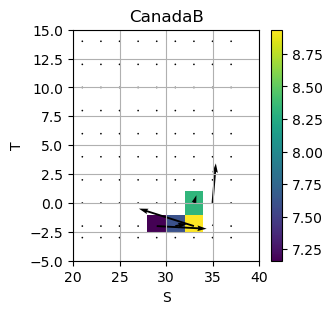

In [159]:
# TS diagrams. Did we do this right?
for i in range(len(strb[:1])):
    plt.figure(i+1,figsize=(3,3))
    plt.pcolormesh(Sbin[iiS,:][:,iiT],Tbin[iiS,:][:,iiT],np.log10(vol_distrib[strb[i]][iiS,:][:,iiT]))
    plt.grid()
    plt.title(strb[i])
    plt.xlabel('S')
    plt.ylabel('T')
    plt.xlim(20,40)
    plt.ylim(-5,15)
    plt.colorbar()

    # try to make the quivers
    Usel = Jx[strb[i]]['LSto_TS'][iiS,:][:,iiT]
    Vsel = Jy[strb[i]]['LTto_TS'][iiS,:][:,iiT]
    
    hh = plt.quiver(Sbin2[iiS,:][:,iiT], Tbin2[iiS,:][:,iiT], Usel, Vsel, scale=1,width=0.01)